使用Python绘制直方图的所有方法，大致可分为三大类（详细划分是五类，参照文末总结）：  
纯Python实现直方图，不使用任何第三方库  
使用Numpy来创建直方图总结数据  
使用matplotlib，pandas，seaborn绘制直方图  

# 纯Python实现histogram
当准备用纯Python来绘制直方图的时候，最简单的想法就是将每个值出现的次数以报告形式展示。  
这种情况下，使用 字典 来完成这个任务是非常合适的，我们看看下面代码是如何实现的。

In [1]:
a = (0, 1, 1, 1, 2, 3, 7, 7, 23)

def count_elements(seq)->dict:
    """Tally elements from 'seq'."""
    hist = {}
    for i in seq:
        hist[i] = hist.get(i, 0) + 1
    return hist

counted = count_elements(a)
print(counted)

{0: 1, 1: 3, 2: 1, 3: 1, 7: 2, 23: 1}


实际上，这个功能可以用一个Python的标准库 collection.Counter 类来完成，  
它兼容Pyhont 字典并覆盖了字典的 .update() 方法

In [2]:
from collections import Counter
recounted = Counter(a)
print(recounted)

Counter({1: 3, 7: 2, 0: 1, 2: 1, 3: 1, 23: 1})


In [4]:
print(recounted.items())
print(counted.items())

dict_items([(0, 1), (1, 3), (2, 1), (3, 1), (7, 2), (23, 1)])
dict_items([(0, 1), (1, 3), (2, 1), (3, 1), (7, 2), (23, 1)])


我们利用上面的函数重新再造一个轮子 ASCII_histogram，并最终通过Python的输出格式format来实现直方图的展示，代码如下：

In [5]:
def ascii_histogram(seq) -> None:
    """A horizontal frequency-table/histogram plot."""
    counted = count_elements(seq)
    for k in sorted(counted):
        print('{0:5d}{1}'.format(k, '+' * counted[k]))

这个函数按照数值大小顺序进行绘图，数值出现次数用 (+) 符号表示。在字典上调用 sorted() 将会返回一个按键顺序排列的列表，然后就可以获取相应的次数 counted[k] 。

In [6]:
import random
random.seed(1)

vals = [1, 3, 4, 6, 8, 9, 10]
# vals里面的数字将会出现5到15次
freq = (random.randint(5, 15) for _ in vals)

data = []
for f, v in zip(freq, vals):
    data.extend([v] * f)
    
ascii_histogram(data)

    1+++++++
    3++++++++++++++
    4++++++
    6+++++++++
    8++++++
    9++++++++++++
   10++++++++++++


这个代码中，vals内的数值是不重复的，并且每个数值出现的频数是由我们自己定义的，在5和15之间随机选择。  
然后运用我们上面封装的函数，就得到了纯Python版本的直方图展示。  
总结：纯python实现频数表（非标准直方图），可直接使用collection.Counter方法实现。

# 使用Numpy实现histogram
以上是使用纯Python来完成的简单直方图，但是从数学意义上来看，直方图是分箱到频数的一种映射，  
它可以用来估计变量的概率密度函数的。而上面纯Python实现版本只是单纯的频数统计，不是真正意义上的直方图。

因此，我们从上面实现的简单直方图继续往下进行升级。一个真正的直方图首先应该是将变量分区域（箱）的，  
也就是分成不同的区间范围，然后对每个区间内的观测值数量进行计数。恰巧，Numpy的直方图方法就可以做到这点，  
不仅仅如此，它也是后面将要提到的matplotlib和pandas使用的基础。

举个例子，来看一组从拉普拉斯分布上提取出来的浮点型样本数据。这个分布比标准正态分布拥有更宽的尾部，并有两个描述参数（location和scale）：

In [7]:
import numpy as np
np.random.seed(444)
np.set_printoptions(precision=3)

d = np.random.laplace(loc=15, scale=3, size=500)
print(d[:5])

[18.406 18.087 16.004 16.221  7.358]


由于这是一个连续型的分布，对于每个单独的浮点值（即所有的无数个小数位置）并不能做很好的标签  
（因为点实在太多了）。但是，你可以将数据做 分箱 处理，然后统计每个箱内观察值的数量，这就是真正的直方图所要做的工作。

下面我们看看是如何用Numpy来实现直方图频数统计的。

In [8]:
hist, bin_edges = np.histogram(d)
# 频数
print(hist)
# 边界
print(bin_edges)

[ 13  23  91 261  80  21   7   2   1   1]
[ 2.11   5.874  9.638 13.402 17.166 20.93  24.694 28.458 32.222 35.986
 39.749]


这个结果可能不是很直观。来说一下，np.histogram() 默认地使用10个相同大小的区间（箱），然后返回一个元组（频数，分箱的边界），如上所示。要注意的是：这个边界的数量是要比分箱数多一个的，可以简单通过下面代码证实。

In [9]:
print(hist.size, bin_edges.size)

10 11


那问题来了，Numpy到底是如何进行分箱的呢？只是通过简单的 np.histogram() 就可以完成了，但具体是如何实现的我们仍然全然不知。下面让我们来将 np.histogram() 的内部进行解剖，看看到底是如何实现的（以最前面提到的a列表为例）。

In [13]:
first_edge, last_edge = min(a), max(a)
n_equal_bins = 10  # numpy默认为10个分箱
bin_edges = np.linspace(start=first_edge, stop=last_edge,
                       num=n_equal_bins + 1, endpoint=True)
print(bin_edges)

[ 0.   2.3  4.6  6.9  9.2 11.5 13.8 16.1 18.4 20.7 23. ]


解释一下：首先获取a列表的最小值和最大值，然后设置默认的分箱数量，最后使用Numpy的 linspace 方法进行数据段分割。分箱区间的结果也正好与实际吻合，0到23均等分为10份，23/10，那么每份宽度为2.3。

除了np.histogram之外，还存在其它两种可以达到同样功能的方法：np.bincount() 和 np.searchsorted()，下面看看代码以及比较结果。

In [15]:
bcounts = np.bincount(a)
print(type(bcounts))
print(len(bcounts))
print(bcounts)
hist, _ = np.histogram(a, range=(0, max(a)), bins=max(a) + 1)
print(hist)
print(np.array_equal(hist, bcounts))

<class 'numpy.ndarray'>
24
[1 3 1 1 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
[1 3 1 1 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
True


In [16]:
# Reproducing collection.Counter
print(dict(zip(np.unique(a), bcounts[bcounts.nonzero()])))

{0: 1, 1: 3, 2: 1, 3: 1, 7: 2, 23: 1}


总结：通过Numpy实现直方图，可直接使用np.histogram()或者np.bincount()。

# 使用Matplotlib和Pandas可视化Histogram

从上面的学习，我们看到了如何使用Python的基础工具搭建一个直方图，下面我们来看看如何使用更为强大的Python库包来完成直方图。Matplotlib基于Numpy的histogram进行了多样化的封装并提供了更加完善的可视化功能。

[ 2.  2.  3.  5.  1.  3.  2.  9. 10. 17. 15. 26. 26. 51. 70. 69. 54. 31.
 28. 23.  7. 14. 11.  6.  4.  0.  1.  3.  1.  2.  1.  1.  0.  0.  0.  0.
  0.  1.  0.  0.  0.  0.  0.  1.]
[ 2.11   2.966  3.821  4.677  5.532  6.387  7.243  8.098  8.954  9.809
 10.665 11.52  12.376 13.231 14.086 14.942 15.797 16.653 17.508 18.364
 19.219 20.074 20.93  21.785 22.641 23.496 24.352 25.207 26.063 26.918
 27.773 28.629 29.484 30.34  31.195 32.051 32.906 33.761 34.617 35.472
 36.328 37.183 38.039 38.894 39.749]
<a list of 44 Patch objects>


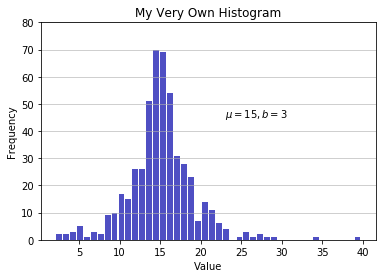

In [19]:
import matplotlib.pyplot as plt

#  matplotlib.axes.Axes.hist() 方法的接口
n, bins, patches = plt.hist(x=d, bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)
print(n)
print(bins)
print(patches)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('My Very Own Histogram')
plt.text(23, 45, r'$\mu=15, b=3$')
maxfreq = max(n)
# 设置y轴的上限
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

plt.show()

之前我们的做法是，在x轴上定义了分箱边界，y轴是相对应的频数，不难发现我们都是手动定义了分箱的数目。但是在以上的高级方法中，我们可以通过设置 bins='auto' 自动在写好的两个算法中择优选择并最终算出最适合的分箱数。这里，算法的目的就是选择出一个合适的区间（箱）宽度，并生成一个最能代表数据的直方图来。

如果使用Python的科学计算工具实现，那么可以使用Pandas的 Series.histogram() ，并通过 matplotlib.pyplot.hist() 来绘制输入Series的直方图，如下代码所示。

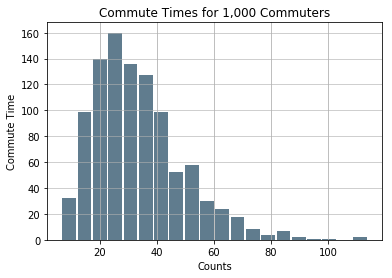

In [22]:
import pandas as pd

size, scale = 1000, 10
commutes = pd.Series(np.random.gamma(scale, size=size) ** 1.5)
commutes.plot.hist(grid=True, bins=20, rwidth=0.9, color='#607c8e')
plt.title('Commute Times for 1,000 Commuters')
plt.xlabel('Counts')
plt.ylabel('Commute Time')
plt.grid(axis='y', alpha=0.75)

plt.show()

pandas.DataFrame.histogram() 的用法与Series是一样的，但生成的是对DataFrame数据中的每一列的直方图。  
总结：通过pandas实现直方图，可使用Seris.plot.hist()，DataFrame.plot.hist()，matplotlib实现直方图可以用matplotlib.pyplot.hist()。

# 绘制核密度估计（KDE）
KDE（Kernel density estimation）是核密度估计的意思，它用来估计随机变量的概率密度函数，可以将数据变得更平缓。

使用Pandas库的话，你可以使用 plot.kde() 创建一个核密度的绘图，plot.kde() 对于 Series和DataFrame数据结构都适用。但是首先，我们先生成两个不同的数据样本作为比较（两个正太分布的样本）：


In [23]:
# 两个正态分布的样本
means = 10, 20
stdevs = 4, 2
dist = pd.DataFrame(np.random.normal(loc=means, scale=stdevs, size=(1000, 2)),
                   columns=['a', 'b'])
dist.agg(['min', 'max', 'mean', 'std']).round(decimals=2)

,a,b
min,-3.78,12.55
max,23.28,26.54
mean,9.99,19.99
std,4.03,2.01


以上看到，我们生成了两组正态分布样本，并且通过一些描述性统计参数对两组数据进行了简单的对比。现在，我们可以在同一个Matplotlib轴上绘制每个直方图以及对应的kde，使用pandas的plot.kde()的好处就是：它会自动的将所有列的直方图和kde都显示出来，用起来非常方便，具体代码如下：

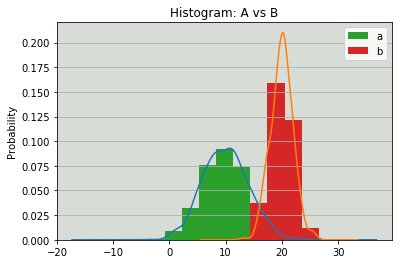

In [26]:
fig, ax = plt.subplots()
dist.plot.kde(ax=ax, legend=False, title='Histogram: A vs B')
dist.plot.hist(density=True, ax=ax)
ax.set_ylabel('Probability')
ax.grid(axis='y')
ax.set_facecolor('#d8dcd6')

plt.show()

总结：通过pandas实现kde图，可使用Seris.plot.kde()，DataFrame.plot.kde()。

# 使用Seaborn的完美替代
一个更高级可视化工具就是Seaborn，它是在matplotlib的基础上进一步封装的强大工具。对于直方图而言，Seaborn有 distplot() 方法，可以将单变量分布的直方图和kde同时绘制出来，而且使用及其方便，下面是实现代码（以上面生成的d为例）：

D:\python\Anaconda3\install\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


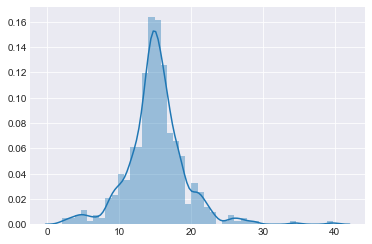

In [27]:
import seaborn as sns

sns.set_style('darkgrid')
sns.distplot(d)

distplot方法默认的会绘制kde，并且该方法提供了 fit 参数，可以根据数据的实际情况自行选择一个特殊的分布来对应。

D:\python\Anaconda3\install\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


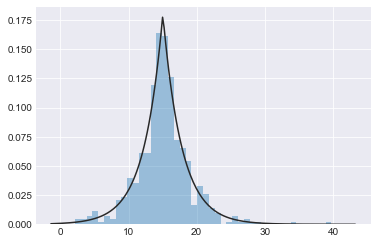

In [35]:
import scipy.stats
sns.distplot(d, fit=scipy.stats.laplace, kde=False)

总结：通过seaborn实现直方图，可使用seaborn.distplot()，seaborn也有单独的kde绘图seaborn.kde()。

# 在Pandas中的其它工具
除了绘图工具外，pandas也提供了一个方便的.value_counts() 方法，用来计算一个非空值的直方图，并将之转变成一个pandas的series结构，示例如下：

In [47]:
data = np.random.choice(np.arange(10), size=10000, p=np.linspace(1, 11, 10) / 60)
s = pd.Series(data)
print(s.value_counts())
print()
print(s.value_counts(normalize=True).head())

9    1809
8    1676
7    1456
6    1302
5    1098
4     898
3     714
2     535
1     336
0     176
dtype: int64

9    0.1809
8    0.1676
7    0.1456
6    0.1302
5    0.1098
dtype: float64


此外，pandas.cut() 也同样是一个方便的方法，用来将数据进行强制的分箱。比如说，我们有一些人的年龄数据，并想把这些数据按年龄段进行分类，示例如下：

In [50]:
ages = pd.Series([1, 1, 3, 5, 8, 10, 12, 15, 18, 18, 19, 20, 25, 30, 40, 51, 52])
bins = (0, 10, 13, 18, 21, np.inf)  # 边界
labels = ('child', 'preteen', 'teen', 'military_age', 'adult')
groups = pd.cut(ages, bins=bins, labels=labels)

print(groups.value_counts())
print()
print(pd.concat((ages, groups), axis=1).rename(columns={0: 'age', 1: 'group'}))

child           6
adult           5
teen            3
military_age    2
preteen         1
dtype: int64

    age         group
0     1         child
1     1         child
2     3         child
3     5         child
4     8         child
5    10         child
6    12       preteen
7    15          teen
8    18          teen
9    18          teen
10   19  military_age
11   20  military_age
12   25         adult
13   30         adult
14   40         adult
15   51         adult
16   52         adult


总结：其它实现直方图的方法，可使用.value_counts()和pandas.cut()。